# NASNetLarge
### Training + Evaluation Pipeline

## To Do:
- apply filtered Data
    - show incorrect + correct images 

In [1]:
import numpy as np
import pandas as pd 
import os
from glob import glob
from random import shuffle
from time import time

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from imgaug import augmenters as iaa
import imgaug as ia
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution1D, concatenate, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, Embedding, \
    Conv2D, SeparableConv1D, Add, BatchNormalization, Activation, GlobalAveragePooling2D, LeakyReLU, Flatten
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D
from keras.layers.pooling import _GlobalPooling1D
from keras.losses import mae, sparse_categorical_crossentropy, binary_crossentropy
from keras.models import Model
from keras.applications.nasnet import NASNetMobile, NASNetLarge, preprocess_input
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint, Callback, LambdaCallback
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

file_path = '../metastases/'
print(os.listdir(file_path))

Using TensorFlow backend.


['.ipynb_checkpoints', 'base_dir', 'Ensemble.ipynb', 'k-fold-crossvalidation.ipynb', 'NasNet & VGG.ipynb', 'NASNetL.weights.best.hdf5', 'NASNetLarge.ipynb', 'NASNetLarge_Filtered_Data.h5', 'NASNetLarge_Filtered_Data_2.h5', 'NASNetL_Filtered_Data.csv', 'NASNetM + Xception.ipynb', 'NASNet_3.weights.best.hdf5', 'NASNet_Xception_2_weights.h5', 'NASNet_Xception_tuned_weights.h5', 'NASNet_Xception_weights.h5', 'OUT_no_tumor', 'Pytorch_fastai.ipynb', 'submissions', 'test', 'train', 'train_labels.csv', 'VGG2heatmap2CNN.ipynb', 'VGG_All.weights.best.hdf5', 'VGG_categorical_all.weights.best.hdf5', 'VGG_cat_home.ipynb', 'weights', 'Xception_All.weights.best.hdf5']


In [ ]:
#Visualizing data without augmentation
def show_data(df, file_path):
    fig, ax = plt.subplots(2,5, figsize=(20,5))
    for i, row in enumerate(df.itertuples()):
        path = os.path.join(file_path, row.id)
        img = Image.open(path+'.tif')
        w,h = img.size
        cropped = img.crop((w//2 - 32//2, h//2 - 32//2, w//2 + 32//2, h//2 + 32//2))
        box = patches.Rectangle((32,32),32,32,linewidth=2,edgecolor='r', facecolor='none')
        ax[0,i].imshow(img)
        ax[0,i].add_patch(box)
        ax[0,i].set_title("Label: {}".format(row.label))
        ax[1,i].imshow(cropped)
        ax[0,0].set_ylabel('Sample', size='large')
        ax[1,0].set_ylabel('Cropped', size='large')
                
def get_id_from_file_path(file_path):
    return file_path.split(os.path.sep)[-1].replace('.tif', '')

#dataaugmentation from https://imgaug.readthedocs.io/en/latest/index.html
def chunker(seq, size): #slices input(seq) into batches with the size=batch_size
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def get_seq():#image augmentation
    sometimes = lambda aug: iaa.Sometimes(0.4, aug)
    seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.5), # vertically flip 20% of all images
            sometimes(iaa.Affine(
                scale={"x": (0.9, 1.2), "y": (0.9, 1.2)}, #>20 will cut part of img
                translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, # >20% will also cut part of img
                rotate=(-10, 10), # 45/-45° -> works good with scale + translate to prevent cuts
                #shear=(-5, 5), # shear by -16 to +16 degrees
                mode=ia.ALL 
            )),
            iaa.SomeOf((0, 3), [
                    sometimes(iaa.Superpixels(p_replace=(0, 0.8), n_segments=(10, 200))), #superpixel-representation --> better basallamina representation 
                    iaa.OneOf([
                        #iaa.GaussianBlur((0, 1)), #dont know
                        iaa.AverageBlur(k=(3, 5)), # k must be odd
                        iaa.MedianBlur(k=(3, 5)), # 
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), #cell wall represenation
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 1.0)), #cell wall represenation
                    #searching for edges or angles --> blobby mask --> better basallamina representation / nuclei
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.2, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.2), # add gaussian noise to images
                 iaa.OneOf([
                        iaa.Dropout((0.01, 0.03), per_channel=0.2), #rnd remove 5% in small pixels
                        iaa.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),# rnd remove 3% in big pixels
                    ]),
                    #iaa.Invert(0.01, per_channel=True), # invert color channels
                    #iaa.Add((-10, 10), per_channel=0.3), # change brightness of images (by -10 to 10 of original value)
                    #iaa.AddToHueAndSaturation((-0.2, 0.2)), # change hue and saturation
                    #
                    #either change the brightness of the whole image (sometimes per channel) or change the brightness of subareas
                    iaa.OneOf([
                        #iaa.Multiply((0.9, 1.1), per_channel=0.5),
                        #iaa.FrequencyNoiseAlpha(
                            #exponent=(-1, 0),
                            #first=iaa.Multiply((0.9, 1.1), per_channel=True),
                            #second=iaa.ContrastNormalization((0.9, 1.1))
                        #)
                    ]),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), #still not sure: move pixels locally around
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), #still not sure:move parts of the image around
                    #sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                         random_order=True
            )
        ],
        random_order=True
    )
    return seq

#new imagedatagenerator
def data_gen(list_files, id_label_map, batch_size, augment=False): #returns a generator function / dataaugmentation off by default
    seq = get_seq()
    while True:
        shuffle(list_files)
        for batch in chunker(list_files, batch_size):
            X = [cv2.imread(x) for x in batch]
            Y = [id_label_map[get_id_from_file_path(x)] for x in batch]
            if augment:
                X = seq.augment_images(X)
            X = [preprocess_input(x.astype(np.float32)) for x in X]#.astype(np.float32) to prevent true divide error                
            yield np.array(X), np.array(Y) # --> yield works like a buffer over each iteration

#visualize data-augmentation
def looking_at_augmentation (data_generator, x, y, batch_size, augmentation):
    datagen = data_generator(x, y, batch_size, augmentation)# initialize custom data-generator
    im, label = next(datagen)
    
    im = (im - np.min(im))/np.ptp(im) # to normalize all images --> matplotlib only takes pos. values between 0..1 / 0..255 
    imgs = list(im)
    labels = list(label)
    
    fig, ax = plt.subplots(ncols=3, nrows=3)
    fig.subplots_adjust(hspace=0.5)
    plt.suptitle('Augmented Images', fontsize=16)
    plt.figure(num=None, figsize=(50, 50), dpi=100, facecolor='w', edgecolor='k')

    for ax in ax.flatten():
        ax.axis('off')

    for i, im  in enumerate(imgs):
        ax = fig.add_subplot(3,3,i+1)
        ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        fig.set_figheight(8)
        fig.set_figwidth(8)

    #fig.tight_layout()
    #fig.savefig('Augmented-Images.png', dpi=100)

#fast plot of training history
def plot_history(history, modelname):
    hist_df = pd.DataFrame(history.history)
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_acc, lw=5, label='Validation Accuracy')
    axs[0].plot(hist_df.acc, lw=5, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=5, label='Validation MLogLoss')
    axs[1].plot(hist_df.loss, lw=5, label='Training MLogLoss')
    axs[1].set_ylabel('MLogLoss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)
    #fig.savefig('History_{}.png' .format(modelname), dpi=300)
    plt.show();

from sklearn.metrics import roc_curve, roc_auc_score, auc#plotting the receiver operating characteristics --> evaluate performance cutting point vice
def plot_roc(label, predictions): #IDEA: set diffrent cutting point based on ROC for ensembling   
    roc_auc_score(label, predictions)
    print('The ROC-Score is: {}' .format(roc_auc_score))

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(label, predictions)
    auc_keras = auc(fpr_keras, tpr_keras)
    #print(auc_keras)

    fig = plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve: {}' .format(auc_keras))
    plt.legend(loc='best')
    #fig.savefig('ROC-Curve.png', dpi=300)
    plt.show()
    
from sklearn.metrics import confusion_matrix
import itertools
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

from scipy.misc import imread
#list of tiffs to array to plot_correct / incorrect-images + rounding predictions to compare to labels
def prep_im_label (val, y_pred):
    vals = []
    for i in val:
        vals.append(imread(i))
        #q = q+1
        #print(q)
        #print(i)
    vals = np.asarray(vals)    
    print(vals.shape)
    y_pred = np.round(y_pred)
    return(vals, y_pred)

#plotting correctly classified images: https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python
def plot_correct(vals, y_pred, y_label, modelname):
    correct = np.where(y_pred==y_label)[0]
    print ("Found %d correct labels" % len(correct))


    fig, ax = plt.subplots(ncols=3, nrows=3)
    fig.subplots_adjust(hspace=0.5)
    plt.suptitle('Correct Images', fontsize=16)
    plt.figure(num=None, figsize=(50, 50), dpi=100, facecolor='w', edgecolor='k')

    for ax in ax.flatten():
        ax.axis('off')

    for i, correct in enumerate(correct[:9]):
        ax = fig.add_subplot(3,3,i+1)
        ax.imshow(vals[correct])
        ax.set_title("Predicted {}, Class {}".format(y_pred[correct], y_label[correct]), fontsize=10)
        fig.set_figheight(8)
        fig.set_figwidth(8)

    #fig.tight_layout()
    #fig.savefig('Correct_Images_{}.png' .format(modelname), dpi=100)

#Plotting incorrectly classified
def plot_incorrect(vals, y_pred, y_label, modelname):
    incorrect = np.where(y_pred!=y_label)[0]
    print ("Found %d incorrect labels" % len(incorrect))


    fig, ax = plt.subplots(ncols=3, nrows=3)
    fig.subplots_adjust(hspace=0.5)
    plt.suptitle('Incorrect Images', fontsize=16)
    plt.figure(num=None, figsize=(50, 50), dpi=100, facecolor='w', edgecolor='k')

    for ax in ax.flatten():
        ax.axis('off')

    for i, incorrect in enumerate(incorrect[:9]):
        ax = fig.add_subplot(3,3,i+1)
        ax.imshow(vals[incorrect])
        ax.set_title("Predicted {}, Class {}".format(y_pred[incorrect], y_label[incorrect]), fontsize=10)
        fig.set_figheight(8)
        fig.set_figwidth(8)

    #fig.tight_layout()
    #fig.savefig('Incorrect_Images._{}.png' .format(modelname), dpi=100)

In [ ]:
#datapreparation
df_train = pd.read_csv(file_path + "train_labels.csv")
id_label_map = {k:v for k,v in zip(df_train.id.values, df_train.label.values)} #constructing a dict with id to corresponding label

# removing this image because it caused a training error previously
df_train = df_train[df_train['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']
# removing this image because it's black
df_train = df_train[df_train['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

#to show some images
negative_cases_train = df_train[df_train["label"] == 0]
positive_cases_train = df_train[df_train["label"] == 1]
print("Postive cases {:,}, negative cases {:,} in training set.".format(len(positive_cases_train), len(negative_cases_train)))

labeled_files = glob('/home/Deep_Learner/work/local/histopathologic-cancer-detection/train/*.tif')
test_files = glob('/home/Deep_Learner/work/local/histopathologic-cancer-detection/test/*.tif')

#sanity check
print("Number of labeled_files size :", len(labeled_files))
print("Number of test_files size :", len(test_files))

#Test_Train-Split = 0.1
train, val = train_test_split(labeled_files, test_size=0.1, random_state=101010)

print(df_train.head())

In [ ]:
file_path_train = '../metastases/train'
show_data(negative_cases_train[0:5], file_path_train)
show_data(positive_cases_train[0:5], file_path_train)

In [ ]:
looking_at_augmentation(data_gen, train, id_label_map, batch_size=9, augmentation=True)

In [ ]:
def get_model_classif_nasnetl():
    inputs = Input((96, 96, 3))
    base_model_NASNet = NASNetLarge(weights=None, include_top=False, input_shape=(96, 96, 3)) 
    x = base_model_NASNet(inputs)
    out1 = GlobalMaxPooling2D()(x)
    out2 = GlobalAveragePooling2D()(x)
    out3 = Flatten()(x)
    out = Concatenate(axis=-1)([out1, out2, out3])
    out = Dropout(0.7)(out)
    out = Dense(1, activation="sigmoid", name="3_")(out)
    model = Model(inputs, out)
    model.compile(optimizer=Adam(5e-05), loss=binary_crossentropy, metrics=['acc'])
    model.summary()

    return model

model = get_model_classif_nasnetl()

In [ ]:
ReduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto', cooldown=5, min_lr=0.00005)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=15, verbose=1, mode='auto')
tensorboard_callback = TensorBoard(log_dir="logs_NasnetL/{}".format(time()), 
            histogram_freq=0, 
            write_graph=True, write_grads=False, write_images=True)
checkpoint = ModelCheckpoint("NASNetL_3.weights.best.hdf5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')

callbacks_list = [ReduceLR, tensorboard_callback, checkpoint, earlystopping]

In [ ]:
model.load_weights("NASNetL_2.weights.best.hdf5")

In [ ]:
batch_size=128
history = model.fit_generator(
    data_gen(train, id_label_map, batch_size, augment=True),
    validation_data=data_gen(val, id_label_map, batch_size),
    epochs=200, verbose=1,
    callbacks=callbacks_list,
    steps_per_epoch=len(train) // batch_size,
    validation_steps=len(val) // batch_size)

In [ ]:
plot_history(history, modelname = 'NASNetLarge')

In [ ]:
#evaluate model on validation-data --> weights of best training epoch will be used
batch_size=1
model.load_weights('NASNetL_2.weights.best.hdf5')
validation_data = data_gen(val, id_label_map, batch_size)
val_loss, val_acc = \
model.evaluate_generator(validation_data,
                         steps=len(val), 
                         verbose=1)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

In [ ]:
#make Predictions on validation-data --> weights of best training epoch will be used
#model.load_weights('NASNetL.weights.best.hdf5')
batch_size=1
validation_data = data_gen(val, id_label_map, batch_size=1)
predictions = []
labels = []
i=0
for i in range((len(val)) // batch_size):
    x, y = next(validation_data)
    prediction = model.predict(x)
    predictions.append(prediction)
    labels.append(y)
    i = i+1
    
    print(i,': Prediction:',prediction, '| Label:',y)

predictions = np.concatenate(predictions)
labels = np.concatenate(labels)

In [ ]:
#Predictions-Dataframe
df_preds = pd.DataFrame(predictions, columns=['Probability of Metastases'])
df_preds.head()
y_pred = df_preds['Probability of Metastases']
#Label-Dataframe
df_labels = pd.DataFrame(labels, columns=['Label'])
df_labels.head()
y_label =df_labels['Label']

In [ ]:
plot_roc(y_label, y_pred)

In [ ]:
cm = confusion_matrix(y_label, y_pred.round())
cm_plot_labels = ['No metastatic tissue', 'Metastatic tissue']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix NASNet')

In [ ]:
vals, y_pred = prep_im_label(val, y_pred)

In [ ]:
plot_correct(vals, y_pred, y_label, modelname='NASNetLarge')
plot_incorrect(vals, y_pred, y_label, modelname='NASNetLarge')

In [ ]:
# making predictions on test-data
batch_size = 64
preds = []
ids = []
for batch in chunker(test_files, batch_size):
    X = [preprocess_input(cv2.imread(x).astype(np.float32)) for x in batch]
    ids_batch = [get_id_from_file_path(x) for x in batch]
    X = np.array(X)
    preds_batch = ((model.predict(X).ravel()*model.predict(X[:, ::-1, :, :]).ravel()*model.predict(X[:, ::-1, ::-1, :]).ravel()*model.predict(X[:, :, ::-1, :]).ravel())**0.25).tolist()
    print(preds_batch)
    preds += preds_batch
    ids += ids_batch

print(len(preds))
df = pd.DataFrame({'id':ids, 'label':preds})
df.to_csv("baseline1_nasnetl.csv", index=False)
df.head()

In [ ]:
!kaggle competitions submit -c histopathologic-cancer-detection -f baseline1_nasnetl.csv -m "NASNetL + Preprocessing + TTA"

## Train on filtered Data

In [2]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#visualize Augmentation from directory!
def looking_at_augmentation (data_generator, batchsize):
    aug_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=batchsize,
                                        class_mode='categorical')

    im, label = next(aug_gen)  
    im = (im - np.min(im))/np.ptp(im) # to normalize all images --> matplotlib only takes pos. values between 0..1 / 0..255 
    imgs = list(im)
    labels = list(label)
    
    fig, ax = plt.subplots(ncols=3, nrows=3)
    fig.subplots_adjust(hspace=0.5)
    plt.suptitle('Augmented Images', fontsize=16)
    plt.figure(num=None, figsize=(50, 50), dpi=100, facecolor='w', edgecolor='k')

    for ax in ax.flatten():
        ax.axis('off')

    for i, im  in enumerate(imgs):
        ax = fig.add_subplot(3,3,i+1)
        ax.imshow(im)
        fig.set_figheight(8)
        fig.set_figwidth(8)

    #fig.tight_layout()
    #fig.savefig('Augmented-Images.png', dpi=100)

#fast plot of training history
def plot_history(history, modelname):
    hist_df = pd.DataFrame(history.history)
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_acc, lw=5, label='Validation Accuracy')
    axs[0].plot(hist_df.acc, lw=5, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=5, label='Validation MLogLoss')
    axs[1].plot(hist_df.loss, lw=5, label='Training MLogLoss')
    axs[1].set_ylabel('MLogLoss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)
    fig.savefig('History_{}.png' .format(modelname), dpi=300)
    plt.show();

from sklearn.metrics import roc_curve, roc_auc_score, auc#plotting the receiver operating characteristics --> evaluate performance cutting point vice
def plot_roc(label, predictions): #IDEA: set diffrent cutting point based on ROC for ensembling   
    roc_auc_score(label, predictions)
    print('The ROC-Score is: {}' .format(roc_auc_score))

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(label, predictions)
    auc_keras = auc(fpr_keras, tpr_keras)
    #print(auc_keras)

    fig = plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve: {}' .format(auc_keras))
    plt.legend(loc='best')
    #fig.savefig('ROC-Curve.png', dpi=300) #saving PLOT 
    plt.show()
    
from sklearn.metrics import confusion_matrix
import itertools
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    #fig.savefig('Confusion-Matrix.png', dpi=100)

#plotting correctly classified images: https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python
def plot_correct(vals, y_pred, y_label, modelname):
    correct = np.where(y_pred==y_label)[0]
    print ("Found %d correct labels" % len(correct))


    fig, ax = plt.subplots(ncols=3, nrows=3)
    fig.subplots_adjust(hspace=0.5)
    plt.suptitle('Correct Images', fontsize=16)
    plt.figure(num=None, figsize=(50, 50), dpi=100, facecolor='w', edgecolor='k')

    for ax in ax.flatten():
        ax.axis('off')

    for i, correct in enumerate(correct[:9]):
        ax = fig.add_subplot(3,3,i+1)
        ax.imshow(vals[correct])
        ax.set_title("Predicted {}, Class {}".format(y_pred[correct], y_label[correct]), fontsize=10)
        fig.set_figheight(8)
        fig.set_figwidth(8)

    #fig.savefig('Correct_Images_{}.png' .format(modelname), dpi=100) #saving PLOT 

#Plotting incorrectly classified
def plot_incorrect(vals, y_pred, y_label, modelname):
    incorrect = np.where(y_pred!=y_label)[0]
    print ("Found %d incorrect labels" % len(incorrect))


    fig, ax = plt.subplots(ncols=3, nrows=3)
    fig.subplots_adjust(hspace=0.5)
    plt.suptitle('Incorrect Images', fontsize=16)
    plt.figure(num=None, figsize=(50, 50), dpi=100, facecolor='w', edgecolor='k')

    for ax in ax.flatten():
        ax.axis('off')

    for i, incorrect in enumerate(incorrect[:9]):
        ax = fig.add_subplot(3,3,i+1)
        ax.imshow(vals[incorrect])
        ax.set_title("Predicted {}, Class {}".format(y_pred[incorrect], y_label[incorrect]), fontsize=10)
        fig.set_figheight(8)
        fig.set_figwidth(8)

    #fig.savefig('Incorrect_Images._{}.png' .format(modelname), dpi=100) #saving PLOT 

In [3]:
import imgaug as ia
from imgaug import augmenters as iaa
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.5), # vertically flip 20% of all images
        sometimes(iaa.Affine(
            scale={"x": (0.9, 1.6), "y": (0.9, 1.6)}, #>20 will cut part of img
            translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, # >20% will also cut part of img
            rotate=(-10, 10), # 45/-45° -> works good with scale + translate to prevent cuts
            shear=(-5, 5), # shear by -16 to +16 degrees
            mode=ia.ALL 
        )),
        iaa.SomeOf((0, 4), [
                sometimes(iaa.Superpixels(p_replace=(0.2, 0.5), n_segments=(10, 100))), #superpixel-representation --> better basallamina representation 
                iaa.OneOf([
                    iaa.GaussianBlur((0, 0.1)), #small blur effects --> better representation
                    iaa.AverageBlur(k=(1, 3)), # k must be odd
                    iaa.MedianBlur(k=(1, 3)), # 
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), #cell wall represenation
                iaa.Emboss(alpha=(0, 0.8), strength=(0, 0.5)), #cell wall represenation
                #searching for edges or angles --> blobby mask --> better basallamina representation / nuclei
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.2, 0.4)), #detects edges --> cell wall,..
                    iaa.DirectedEdgeDetect(alpha=(0.2, 0.4), direction=(0.0, 1.0)), #direction will make edges from random directions 
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.2), # add gaussian noise to images
             iaa.OneOf([
                    iaa.Dropout((0.01, 0.03), per_channel=0.2), #rnd remove 5% in small pixels
                    iaa.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),# rnd remove 3% in big pixels
                ]),
                iaa.Invert(0.01, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.3), # change brightness of images (by -10 to 10 of original value)
                #iaa.AddToHueAndSaturation((-0.1, 0.1)), # change hue and saturation
                #
                #either change the brightness of the whole image (sometimes per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.9, 1.1), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-1, 0),
                        first=iaa.Multiply((0.9, 1.1), per_channel=True),
                        second=iaa.ContrastNormalization((0.9, 1.1))
                    )
                ]),
                sometimes(iaa.ElasticTransformation(alpha=(0, 0.5), sigma=0.1)), #still not sure: move pixels locally around
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.02))), #still not sure:move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
                     random_order=True
        )
    ],
    random_order=True
)


In [5]:
train_path = file_path + '/base_dir/train_dir'
valid_path = file_path + '/base_dir/val_dir'
test_path = file_path + '/test/'

num_train_samples = 142332
num_val_samples = 15904

train_batch_size_1 = 32
train_batch_size_2 = 64

val_batch_size = 64

train_steps_1 = np.ceil(num_train_samples / train_batch_size_1)
train_steps_2 = np.ceil(num_train_samples / train_batch_size_2)
val_steps = np.ceil(num_val_samples / val_batch_size)

IMAGE_SIZE = 96
#datagenerators
datagen = ImageDataGenerator(preprocessing_function=seq.augment_image,
                            rescale=1./255)

datagen_valid = ImageDataGenerator(rescale=1./255)

train_gen_1 = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size_1,
                                        class_mode='binary')

train_gen_2 = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size_2,
                                        class_mode='binary')

val_gen = datagen_valid.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

Found 142332 images belonging to 2 classes.
Found 142332 images belonging to 2 classes.
Found 15904 images belonging to 2 classes.


Found 142332 images belonging to 2 classes.


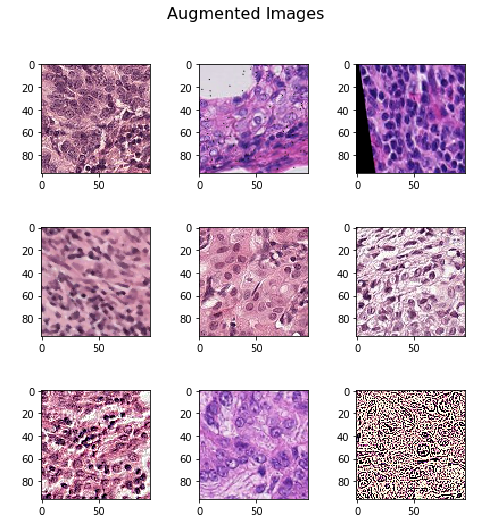

<Figure size 5000x5000 with 0 Axes>

In [6]:
looking_at_augmentation(datagen, batchsize=9)

In [7]:
def get_model_classif_nasnetl():
    inputs = Input((96, 96, 3))
    base_model_NASNet = NASNetLarge(include_top=False, input_shape=(96, 96, 3)) 
    x = base_model_NASNet(inputs)
    out1 = GlobalMaxPooling2D()(x)
    out2 = GlobalAveragePooling2D()(x)
    out3 = Flatten()(x)
    out = Concatenate(axis=-1)([out1, out2, out3])
    out = Dropout(0.6)(out)
    out = Dense(1, activation="sigmoid", name="3_")(out)
    model_NASNetLarge = Model(inputs, out)
    model_NASNetLarge.compile(optimizer=Adam(5e-05), loss=binary_crossentropy, metrics=['acc'])
    model_NASNetLarge.summary()

    return model_NASNetLarge

model = get_model_classif_nasnetl()
#model_NASNetLarge.load_weights('NASNetL_2.weights.best.hdf5')
#print('Model NASNetLarge loaded!')

def get_callbacks(name_weights):
    ReduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto', cooldown=5, min_lr=0.00005)
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=15, verbose=1, mode='auto')
    checkpoint = ModelCheckpoint(name_weights, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    return [earlystopping, ReduceLR, checkpoint]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
NASNet (Model)                  (None, 3, 3, 4032)   84916818    input_1[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 4032)         0           NASNet[1][0]                     
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 4032)         0           NASNet[1][0]                     
__________________________________________________________________________________________________
flatten_1 

In [8]:
name_weights = "NASNetLarge_Filtered_Data_2.h5"
callbacks_list = get_callbacks(name_weights = name_weights)

In [ ]:
history = model.fit_generator(train_gen_1, steps_per_epoch=train_steps_1, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=2, verbose=1,
                    callbacks=callbacks_list,
                    workers=6,
                    max_queue_size = 15)

In [9]:
model.load_weights('NASNetLarge_Filtered_Data_2.h5')
history = model.fit_generator(train_gen_2, steps_per_epoch=train_steps_2, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=50, verbose=1,
                    callbacks=callbacks_list,
                    workers=8,
                    max_queue_size = 15)

Epoch 1/50
2224/2224 [==============================] - 1303s 586ms/step - loss: 0.0622 - acc: 0.9756 - val_loss: 0.0659 - val_acc: 0.9823

Epoch 00001: val_acc improved from -inf to 0.98227, saving model to NASNetLarge_Filtered_Data_2.h5
Epoch 2/50
2224/2224 [==============================] - 1243s 559ms/step - loss: 0.0629 - acc: 0.9752 - val_loss: 0.0658 - val_acc: 0.9825

Epoch 00002: val_acc improved from 0.98227 to 0.98252, saving model to NASNetLarge_Filtered_Data_2.h5
Epoch 3/50
2224/2224 [==============================] - 1243s 559ms/step - loss: 0.0613 - acc: 0.9758 - val_loss: 0.0777 - val_acc: 0.9798

Epoch 00003: val_acc did not improve from 0.98252
Epoch 4/50
2224/2224 [==============================] - 1244s 559ms/step - loss: 0.0604 - acc: 0.9762 - val_loss: 0.0646 - val_acc: 0.9820

Epoch 00004: val_acc did not improve from 0.98252
Epoch 5/50
2224/2224 [==============================] - 1244s 560ms/step - loss: 0.0577 - acc: 0.9770 - val_loss: 0.0672 - val_acc: 0.9828


## Model Evalutation

In [10]:
# Setup the data_frame: Path, ID, Label, Image
valid_path = file_path + '/base_dir/val_dir/'
no_met_path = valid_path + 'a_no_tumor_tissue'
met_path = valid_path + 'b_has_tumor_tissue'
#neg folder
df_validation = pd.DataFrame({'path': glob(os.path.join(no_met_path,'*.tif'))})
df_validation['id'] = df_validation.path.map(lambda x: x.split('\\')[1].split('.')[0]) 
df_validation['label'] = 0
#pos folder
df_validation_pos = pd.DataFrame({'path': glob(os.path.join(met_path,'*.tif'))})
df_validation_pos['id'] = df_validation_pos.path.map(lambda x: x.split('\\')[1].split('.')[0]) 
df_validation_pos['label'] = 1
#both
df_validation = pd.concat([df_validation, df_validation_pos])
#add images
df_validation['image'] = df_validation['path'].map(imread)

df_validation.head()
df_validation['x'] = df_validation["path"].map(str) + df_validation["id"]
print(len(df_validation))
df_validation.head

NameError: name 'imread' is not defined

In [ ]:
y_label = (df_validation['label'])
print(y_label)

In [ ]:
batch_size=1
datagen_test = ImageDataGenerator(rescale=1./255)

test_generator = datagen_test.flow_from_directory(valid_path, 
                                                  batch_size = batch_size, 
                                                  shuffle=False,#FALSEFALSEFALSEFALSEFALSEFALSEFALSEFALSEFALSEFALSEFALSEFALSE
                                                  target_size=(IMAGE_SIZE,IMAGE_SIZE), 
                                                  class_mode='binary')

#evaluate model on validation-data + test_datagen --> weights of best training epoch will be used
model_VGG.load_weights("NASNetLarge_Filtered_Data_2.h5")
val_loss, val_acc = \
model_VGG.evaluate_generator(test_generator, 
                             steps=len(df_validation),
                             verbose=1)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

In [ ]:
filenames = test_generator.filenames
print(filenames)

In [ ]:
test_generator.reset()

In [ ]:
predictions = model_VGG.predict_generator(test_generator, 
                                          steps=16000, 
                                          workers=6, 
                                          use_multiprocessing=False, 
                                          verbose=1)

In [ ]:
df_preds = pd.DataFrame(predictions, columns=['has_tumor_tissue'])
print(df_preds.head())
# Get the predicted labels as probabilities
y_pred = df_preds['has_tumor_tissue']

In [ ]:
df_preds = pd.DataFrame(predictions, columns=['has_tumor_tissue'])

print(len(df_preds))

In [ ]:
#rounding predictions + make them int --> compare to label / heatmap
y_pred = y_pred.round()
y_pred_int = []
for i in y_pred:
    if i == 1.0:
        y_pred_int.append(1)
    else:
        y_pred_int.append(0)

y_pred_int = np.asarray(y_pred_int)
print((y_pred_int.shape))

In [ ]:
#maybe change pos/neg cutoff:
plot_roc(y_label, y_pred)

cm = confusion_matrix(y_label, y_pred.round())
cm_plot_labels = ['No metastatic tissue', 'Metastatic tissue']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix NASNetL')

plot_correct(X, y_pred_int, y_label, modelname='NASNetL')
plot_incorrect(X, y_pred_int, y_label, modelname='NASNetL')

## Model Testing

In [ ]:
model.load_weights('NASNetLarge_Filtered_Data.h5')
test_gen=datagen_valid.flow_from_directory(test_path, batch_size=1, shuffle=False,
                                            class_mode="binary",
                                            target_size=(IMAGE_SIZE,IMAGE_SIZE))

num_test_images = 57458
predictions = model.predict_generator(test_gen, steps=num_test_images, verbose=1)

In [ ]:
# This outputs the file names in the sequence in which 
# the generator processed the test images.
test_filenames = test_gen.filenames
print(len(test_filenames))
# add the filenames to the dataframe
df_preds['file_names'] = test_filenames
df_preds.head

In [ ]:
def extract_id(x):  
    # split into a list
    a = x.split('\\')
    print(a)
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)

y_predictions = df_preds['has_tumor_tissue']

In [ ]:
# get the id column
image_id = df_preds['id']
submission = pd.DataFrame({'id':image_id, 
                           'label':y_predictions, 
                          }).set_index('id')

submission.to_csv('NASNetL_Filtered_Data.csv', columns=['label']) 
submission.head()

In [ ]:
!pip install kaggle

In [ ]:
!kaggle competitions submit -c histopathologic-cancer-detection -f NASNetL_Filtered_Data.csv -m "NASNetL Filtered Data"